In [2]:
import os, gc
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F


from tqdm import tqdm

from Data import load_df, load_npy
from Network import ConvolutionBlock, ASPP_Unet, ssim_loss


path = "data6/"
device = "cuda"

df = load_df(path)
#df = df[df["month"] == 8]
df = df.sort_values(by=["lat", "lon", "year", "month", "day"]).reset_index(drop=True)
df = df[df["mean"] > 0.1]
df.head(20)

,lat,lon,year,month,day,mean,filename
3,-4.39,-55.20,2018,6,1,0.11,Labeled_-4.39_-55.20_2018_06_01_0.11.npy
7,-4.39,-55.20,2020,6,1,0.11,Labeled_-4.39_-55.20_2020_06_01_0.11.npy
9,-4.39,-55.20,2021,5,1,0.13,Labeled_-4.39_-55.20_2021_05_01_0.13.npy
10,-4.39,-55.20,2021,8,1,0.11,Labeled_-4.39_-55.20_2021_08_01_0.11.npy
20,-4.39,-55.18,2021,5,1,0.12,Labeled_-4.39_-55.18_2021_05_01_0.12.npy
38,-4.39,-55.14,2019,7,1,0.11,Labeled_-4.39_-55.14_2019_07_01_0.11.npy
55,-4.39,-55.10,2016,8,1,0.14,Labeled_-4.39_-55.10_2016_08_01_0.14.npy
56,-4.39,-55.10,2017,7,1,0.17,Labeled_-4.39_-55.10_2017_07_01_0.17.npy
57,-4.39,-55.10,2017,8,1,0.16,Labeled_-4.39_-55.10_2017_08_01_0.16.npy
58,-4.39,-55.10,2018,6,1,0.19,Labeled_-4.39_-55.10_2018_06_01_0.19.npy


In [3]:
IM = [-0.0545, -0.0508, -0.0239, -0.0395,  0.2755,  0.1047,  0.0010, 0]
IS = [ 0.0082,  0.0098,  0.0163,  0.0204,  0.0448,  0.0482,  0.0317, 1]

IM = torch.tensor(IM).to(device)
IS = torch.tensor(IS).to(device)

In [4]:
class RandomSimetry(object):
    def __call__(self, sample):
        if torch.rand(1) > 0.5:
            sample = torch.rot90(sample, 1, [1,2])

        if torch.rand(1) > 0.5:
            sample = torch.flip(sample, [1])

        if torch.rand(1) > 0.5:
            sample = torch.flip(sample, [2])

        return sample

In [5]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((64,64)),
            transforms.Normalize(IM, IS),
            RandomSimetry(),
        ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]
        files = series.sample(3, replace=True).sort_values(by=["year", "month", "day"])["filename"].values

        im0 = np.load(self.img_dir + files[0])
        im1 = np.load(self.img_dir + files[1])
        im2 = np.load(self.img_dir + files[2])

        state = torch.get_rng_state()
        im0 = self.transform(im0).to(device)
        torch.set_rng_state(state)
        im1 = self.transform(im1).to(device)
        torch.set_rng_state(state)
        im2 = self.transform(im2).to(device)

        return [im0[:-1, :, :], im1[:-1, :, :], im2[:-1, :, :]], [im0[-1, :, :], im1[-1, :, :], im2[-1, :, :]]
    
positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

test_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

len(train_ds), len(val_ds)

(621, 155)

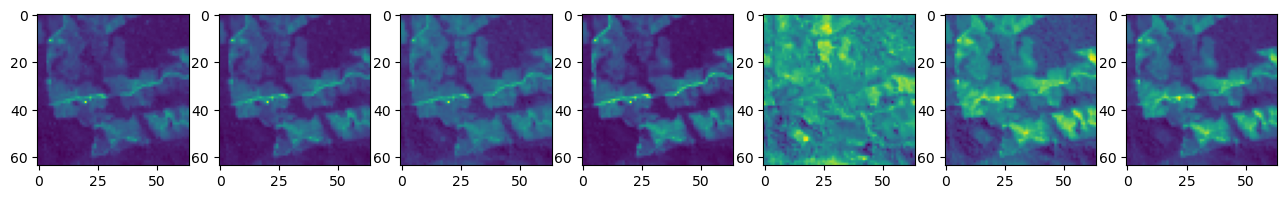

In [6]:
im, lb = next(iter(train_dl))
pi, ci, ni = im
pl, cl, nl = lb

fig, axes = plt.subplots(1, 7, figsize=(16, 16))
for i in range(7):
    axes[i].imshow(ci[0][i].cpu())
plt.show()

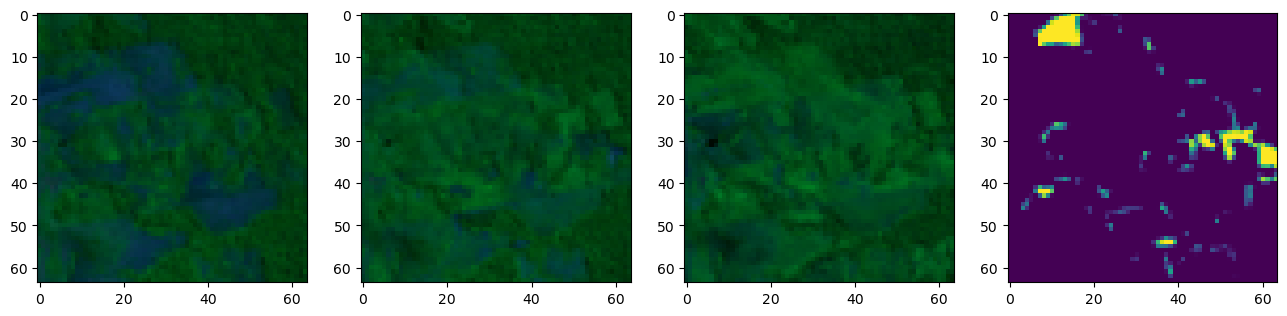

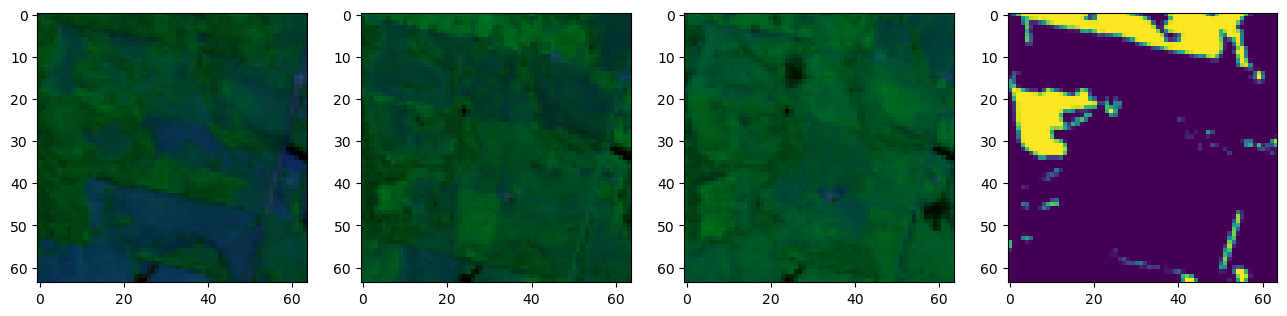

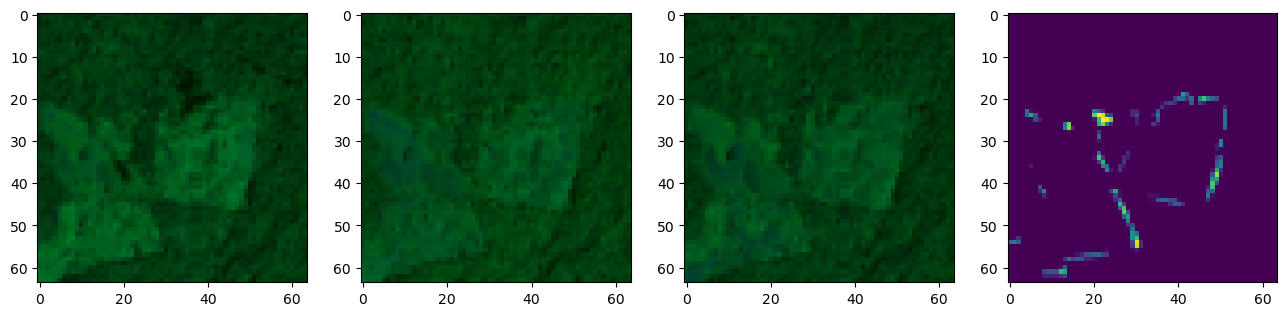

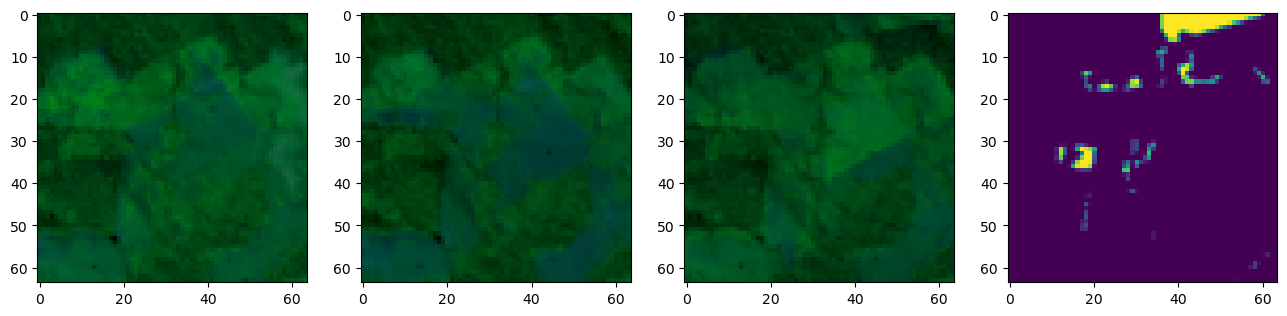

In [7]:
im, lb = next(iter(train_dl))
pi, ci, ni = im
pl, cl, nl = lb

dff = (cl - pl).clamp(0, 1)

for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(16, 16))

    pi[i] = (pi[i] * IS[:-1, None, None]) + IM[:-1, None, None]
    ci[i] = (ci[i] * IS[:-1, None, None]) + IM[:-1, None, None]
    ni[i] = (ni[i] * IS[:-1, None, None]) + IM[:-1, None, None]

    axes[0].imshow(pi[i][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[1].imshow(ci[i][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[2].imshow(ni[i][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[3].imshow(dff[i].cpu())
    plt.show()

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.unet = ASPP_Unet(7, 16)

        self.conv = nn.Sequential(
            ConvolutionBlock(16 * 3, 16 * 3, kernel_size=3, residual=True, bias=False),
            ConvolutionBlock(16 * 3, 16 * 3, kernel_size=3, residual=True, bias=False),
            ConvolutionBlock(16 * 3, 16 * 3, kernel_size=3, residual=True, bias=False),

            nn.Conv2d(16 * 3, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        

    def forward(self, p, c, n):

        p = self.unet(p)
        c = self.unet(c)
        n = self.unet(n)

        x = torch.cat([p, c, n], dim=1)
        x = self.conv(x)

        if not self.training:
            x = (x > 0.5).float()

        return x
    
model = Network().to(device)

In [9]:
bce_loss = nn.BCELoss()
loss_fn = lambda output, target: bce_loss(output, target) + ssim_loss(output, target)

In [10]:
def plot_images():
    model.eval()

    im, lb = next(iter(val_dl))
    pi, ci, ni = im
    pl, cl, nl = lb

    out = model(pi, ci, ni)
    dff = ((cl - pl) > 0.5).float()

    vl = loss_fn(out, dff[:, None, ...])
    print(f"Validation loss: {vl:.4f}")

    pi[0] = (pi[0] * IS[:-1, None, None]) + IM[:-1, None, None]
    ci[0] = (ci[0] * IS[:-1, None, None]) + IM[:-1, None, None]
    ni[0] = (ni[0] * IS[:-1, None, None]) + IM[:-1, None, None]

    fig, axes = plt.subplots(1, 5, figsize=(16, 16))
    axes[0].imshow(pi[0][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[1].imshow(ci[0][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[2].imshow(ni[0][3:6].permute(1, 2, 0).clip(0,1).cpu())
    axes[3].imshow(dff[0].cpu())
    axes[4].imshow(out[0][0].detach().cpu())
    plt.show()
    
    model.train()

In [11]:
def f1_score(dl):
    model.eval()

    im, lb = next(iter(val_dl))
    pi, ci, ni = im
    pl, cl, nl = lb

    output = model(pi, ci, ni)
    dff = ((cl - pl) > 0.5).float()[:, None, ...]

    intersection = torch.sum(output * dff)
    union = torch.sum(output) + torch.sum(dff) - intersection

    tp = torch.sum(output * dff)
    fp = torch.sum(output * (1-dff))
    fn = torch.sum((1-output) * dff)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    iou = intersection / union

    print(f"F1: {f1:.4f} IoU: {iou:.4f}")

    model.train()

    return f1.detach().cpu().numpy() #, iou.detach().cpu().numpy()

In [14]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = tqdm(range(5001))
def closure():
    global pbar

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    pi, ci, ni = im
    pl, cl, nl = lb

    out = model(pi, ci, ni)
    dff = (cl - pl).clamp(0, 1)[:, None, ...]

    loss = loss_fn(out, dff)
    
    pbar.set_description(f"Loss: {loss:.4f}")

    loss.backward()
    return loss

val_losses = []
train_losses = []

model.train()
for i in pbar:
    optimizer.step(closure)

    if i % 100 == 0:
        with torch.no_grad():
            #plot_images()
            
            val_losses.append(f1_score(val_dl))
            gc.collect()
            torch.cuda.empty_cache()

            train_losses.append(f1_score(test_dl))        
            gc.collect()
            torch.cuda.empty_cache()


Loss: 0.3085:   0%|          | 0/5001 [00:00<?, ?it/s]

F1: 0.5028 IoU: 0.3358


Loss: 0.3085:   0%|          | 1/5001 [00:01<2:19:04,  1.67s/it]

F1: 0.5904 IoU: 0.4188


Loss: 0.4400:   2%|▏         | 100/5001 [00:32<25:17,  3.23it/s]

F1: 0.6118 IoU: 0.4407


Loss: 0.4400:   2%|▏         | 101/5001 [00:33<1:01:04,  1.34it/s]

F1: 0.5497 IoU: 0.3790


Loss: 0.6259:   4%|▍         | 200/5001 [01:05<25:20,  3.16it/s]  

F1: 0.5400 IoU: 0.3698


Loss: 0.6259:   4%|▍         | 201/5001 [01:06<1:02:22,  1.28it/s]

F1: 0.4303 IoU: 0.2741


Loss: 0.4022:   6%|▌         | 300/5001 [01:38<25:03,  3.13it/s]  

F1: 0.3919 IoU: 0.2437


Loss: 0.4022:   6%|▌         | 301/5001 [01:39<59:18,  1.32it/s]

F1: 0.5179 IoU: 0.3495


Loss: 0.5150:   8%|▊         | 400/5001 [02:10<24:11,  3.17it/s]

F1: 0.5013 IoU: 0.3345


Loss: 0.5150:   8%|▊         | 401/5001 [02:12<56:13,  1.36it/s]

F1: 0.4607 IoU: 0.2993


Loss: 0.6404:  10%|▉         | 500/5001 [02:44<24:27,  3.07it/s]

F1: 0.5049 IoU: 0.3377


Loss: 0.6404:  10%|█         | 501/5001 [02:45<56:57,  1.32it/s]

F1: 0.4197 IoU: 0.2656


Loss: 0.4878:  12%|█▏        | 600/5001 [03:16<24:06,  3.04it/s]

F1: 0.5177 IoU: 0.3493


Loss: 0.4878:  12%|█▏        | 601/5001 [03:18<56:50,  1.29it/s]

F1: 0.4887 IoU: 0.3233


Loss: 0.5757:  14%|█▍        | 700/5001 [03:49<22:54,  3.13it/s]

F1: 0.5503 IoU: 0.3796


Loss: 0.5757:  14%|█▍        | 701/5001 [03:50<55:33,  1.29it/s]

F1: 0.4980 IoU: 0.3315


Loss: 0.6786:  16%|█▌        | 800/5001 [04:21<19:30,  3.59it/s]

F1: 0.4680 IoU: 0.3055


Loss: 0.6786:  16%|█▌        | 801/5001 [04:23<47:04,  1.49it/s]

F1: 0.5793 IoU: 0.4078


Loss: 0.4322:  18%|█▊        | 900/5001 [04:54<20:58,  3.26it/s]

F1: 0.5335 IoU: 0.3638


Loss: 0.4322:  18%|█▊        | 901/5001 [04:55<50:05,  1.36it/s]

F1: 0.3682 IoU: 0.2257


Loss: 0.6882:  20%|█▉        | 1000/5001 [05:28<22:13,  3.00it/s]

F1: 0.5527 IoU: 0.3819


Loss: 0.6882:  20%|██        | 1001/5001 [05:29<52:41,  1.27it/s]

F1: 0.5426 IoU: 0.3723


Loss: 0.3903:  22%|██▏       | 1100/5001 [06:01<21:30,  3.02it/s]

F1: 0.4660 IoU: 0.3038


Loss: 0.3903:  22%|██▏       | 1101/5001 [06:03<51:31,  1.26it/s]

F1: 0.4467 IoU: 0.2876


Loss: 0.6459:  24%|██▍       | 1200/5001 [06:36<20:43,  3.06it/s]

F1: 0.5529 IoU: 0.3820


Loss: 0.6459:  24%|██▍       | 1201/5001 [06:37<48:43,  1.30it/s]

F1: 0.4952 IoU: 0.3291


Loss: 0.7313:  26%|██▌       | 1300/5001 [07:09<18:52,  3.27it/s]

F1: 0.4721 IoU: 0.3090


Loss: 0.7313:  26%|██▌       | 1301/5001 [07:10<45:14,  1.36it/s]

F1: 0.5823 IoU: 0.4108


Loss: 0.5373:  28%|██▊       | 1400/5001 [07:42<18:18,  3.28it/s]

F1: 0.5596 IoU: 0.3885


Loss: 0.5373:  28%|██▊       | 1401/5001 [07:44<46:20,  1.29it/s]

F1: 0.4719 IoU: 0.3088


Loss: 0.5139:  30%|██▉       | 1500/5001 [08:15<18:40,  3.12it/s]

F1: 0.5967 IoU: 0.4252


Loss: 0.5139:  30%|███       | 1501/5001 [08:17<44:26,  1.31it/s]

F1: 0.5584 IoU: 0.3874


Loss: 0.5247:  32%|███▏      | 1600/5001 [08:48<17:11,  3.30it/s]

F1: 0.5830 IoU: 0.4114


Loss: 0.5247:  32%|███▏      | 1601/5001 [08:50<42:02,  1.35it/s]

F1: 0.5300 IoU: 0.3605


Loss: 0.6170:  34%|███▍      | 1700/5001 [09:21<17:22,  3.17it/s]

F1: 0.5427 IoU: 0.3724


Loss: 0.6170:  34%|███▍      | 1701/5001 [09:22<42:16,  1.30it/s]

F1: 0.4896 IoU: 0.3242


Loss: 0.6185:  36%|███▌      | 1800/5001 [09:53<16:08,  3.31it/s]

F1: 0.6058 IoU: 0.4346


Loss: 0.6185:  36%|███▌      | 1801/5001 [09:54<39:26,  1.35it/s]

F1: 0.3303 IoU: 0.1979


Loss: 0.3439:  38%|███▊      | 1900/5001 [10:26<15:52,  3.25it/s]

F1: 0.4782 IoU: 0.3143


Loss: 0.3439:  38%|███▊      | 1901/5001 [10:27<39:07,  1.32it/s]

F1: 0.4827 IoU: 0.3182


Loss: 0.3857:  40%|███▉      | 2000/5001 [10:58<15:20,  3.26it/s]

F1: 0.4700 IoU: 0.3072


Loss: 0.3857:  40%|████      | 2001/5001 [11:00<36:37,  1.37it/s]

F1: 0.5677 IoU: 0.3964


Loss: 0.7397:  42%|████▏     | 2100/5001 [11:31<16:27,  2.94it/s]

F1: 0.4989 IoU: 0.3323


Loss: 0.7397:  42%|████▏     | 2101/5001 [11:33<41:27,  1.17it/s]

F1: 0.5034 IoU: 0.3364


Loss: 0.4232:  44%|████▍     | 2200/5001 [12:05<16:52,  2.77it/s]

F1: 0.5142 IoU: 0.3461


Loss: 0.4232:  44%|████▍     | 2201/5001 [12:07<39:29,  1.18it/s]

F1: 0.5215 IoU: 0.3527


Loss: 0.7833:  46%|████▌     | 2300/5001 [12:40<15:23,  2.92it/s]

F1: 0.4751 IoU: 0.3116


Loss: 0.7833:  46%|████▌     | 2301/5001 [12:41<35:18,  1.27it/s]

F1: 0.5959 IoU: 0.4244


Loss: 0.6421:  48%|████▊     | 2400/5001 [13:13<13:13,  3.28it/s]

F1: 0.4857 IoU: 0.3208


Loss: 0.6421:  48%|████▊     | 2401/5001 [13:15<31:40,  1.37it/s]

F1: 0.3967 IoU: 0.2474


Loss: 0.6917:  50%|████▉     | 2500/5001 [13:48<14:00,  2.97it/s]

F1: 0.5011 IoU: 0.3343


Loss: 0.6917:  50%|█████     | 2501/5001 [13:50<32:57,  1.26it/s]

F1: 0.4316 IoU: 0.2752


Loss: 0.9874:  52%|█████▏    | 2600/5001 [14:23<13:31,  2.96it/s]

F1: 0.3559 IoU: 0.2165


Loss: 0.9874:  52%|█████▏    | 2601/5001 [14:24<31:21,  1.28it/s]

F1: 0.4902 IoU: 0.3246


Loss: 0.3784:  54%|█████▍    | 2700/5001 [14:56<11:46,  3.26it/s]

F1: 0.5705 IoU: 0.3991


Loss: 0.3784:  54%|█████▍    | 2701/5001 [14:57<28:16,  1.36it/s]

F1: 0.5358 IoU: 0.3659


Loss: 0.6553:  56%|█████▌    | 2800/5001 [15:28<11:03,  3.32it/s]

F1: 0.5056 IoU: 0.3383


Loss: 0.6553:  56%|█████▌    | 2801/5001 [15:29<26:39,  1.38it/s]

F1: 0.3988 IoU: 0.2491


Loss: 0.8312:  58%|█████▊    | 2900/5001 [16:01<10:39,  3.29it/s]

F1: 0.5416 IoU: 0.3714


Loss: 0.8312:  58%|█████▊    | 2901/5001 [16:02<25:35,  1.37it/s]

F1: 0.4706 IoU: 0.3077


Loss: 0.4108:  60%|█████▉    | 3000/5001 [16:35<12:05,  2.76it/s]

F1: 0.5159 IoU: 0.3476


Loss: 0.4108:  60%|██████    | 3001/5001 [16:37<29:17,  1.14it/s]

F1: 0.5248 IoU: 0.3558


Loss: 0.5028:  62%|██████▏   | 3100/5001 [17:10<10:30,  3.01it/s]

F1: 0.4643 IoU: 0.3024


Loss: 0.5028:  62%|██████▏   | 3101/5001 [17:11<24:33,  1.29it/s]

F1: 0.4699 IoU: 0.3071


Loss: 0.8378:  64%|██████▍   | 3200/5001 [17:44<10:01,  3.00it/s]

F1: 0.3551 IoU: 0.2158


Loss: 0.8378:  64%|██████▍   | 3201/5001 [17:46<24:49,  1.21it/s]

F1: 0.6031 IoU: 0.4318


Loss: 0.4985:  66%|██████▌   | 3300/5001 [18:19<09:27,  3.00it/s]

F1: 0.5341 IoU: 0.3644


Loss: 0.4985:  66%|██████▌   | 3301/5001 [18:21<22:15,  1.27it/s]

F1: 0.4870 IoU: 0.3219


Loss: 0.4893:  68%|██████▊   | 3400/5001 [18:54<08:51,  3.01it/s]

F1: 0.5763 IoU: 0.4048


Loss: 0.4893:  68%|██████▊   | 3401/5001 [18:55<21:28,  1.24it/s]

F1: 0.4744 IoU: 0.3110


Loss: 0.4168:  70%|██████▉   | 3500/5001 [19:29<08:32,  2.93it/s]

F1: 0.4659 IoU: 0.3037


Loss: 0.4168:  70%|███████   | 3501/5001 [19:30<21:58,  1.14it/s]

F1: 0.4614 IoU: 0.2999


Loss: 0.7621:  72%|███████▏  | 3600/5001 [20:03<07:10,  3.25it/s]

F1: 0.4521 IoU: 0.2921


Loss: 0.7621:  72%|███████▏  | 3601/5001 [20:04<17:30,  1.33it/s]

F1: 0.4288 IoU: 0.2729


Loss: 0.5442:  74%|███████▍  | 3700/5001 [20:35<07:45,  2.80it/s]

F1: 0.5408 IoU: 0.3706


Loss: 0.5442:  74%|███████▍  | 3701/5001 [20:37<18:24,  1.18it/s]

F1: 0.5370 IoU: 0.3670


Loss: 0.8119:  76%|███████▌  | 3800/5001 [21:10<06:44,  2.97it/s]

F1: 0.5319 IoU: 0.3623


Loss: 0.8119:  76%|███████▌  | 3801/5001 [21:12<17:42,  1.13it/s]

F1: 0.4618 IoU: 0.3002


Loss: 0.6185:  78%|███████▊  | 3900/5001 [21:46<06:12,  2.96it/s]

F1: 0.4915 IoU: 0.3258


Loss: 0.6185:  78%|███████▊  | 3901/5001 [21:47<14:37,  1.25it/s]

F1: 0.5574 IoU: 0.3864


Loss: 0.6796:  80%|███████▉  | 4000/5001 [22:21<05:31,  3.02it/s]

F1: 0.5025 IoU: 0.3356


Loss: 0.6796:  80%|████████  | 4001/5001 [22:22<14:14,  1.17it/s]

F1: 0.4321 IoU: 0.2756


Loss: 0.5002:  82%|████████▏ | 4100/5001 [22:56<04:53,  3.07it/s]

F1: 0.5262 IoU: 0.3570


Loss: 0.5002:  82%|████████▏ | 4101/5001 [22:57<11:56,  1.26it/s]

F1: 0.5116 IoU: 0.3437


Loss: 0.4676:  84%|████████▍ | 4200/5001 [23:28<04:02,  3.30it/s]

F1: 0.5797 IoU: 0.4081


Loss: 0.4676:  84%|████████▍ | 4201/5001 [23:30<09:42,  1.37it/s]

F1: 0.5428 IoU: 0.3724


Loss: 0.6375:  86%|████████▌ | 4300/5001 [24:03<03:45,  3.10it/s]

F1: 0.5409 IoU: 0.3707


Loss: 0.6375:  86%|████████▌ | 4301/5001 [24:05<08:43,  1.34it/s]

F1: 0.6121 IoU: 0.4410


Loss: 0.5736:  88%|████████▊ | 4400/5001 [24:38<03:08,  3.19it/s]

F1: 0.4759 IoU: 0.3123


Loss: 0.5736:  88%|████████▊ | 4401/5001 [24:39<07:29,  1.33it/s]

F1: 0.5981 IoU: 0.4266


Loss: 0.7378:  90%|████████▉ | 4500/5001 [25:12<02:40,  3.12it/s]

F1: 0.5191 IoU: 0.3505


Loss: 0.7378:  90%|█████████ | 4501/5001 [25:13<06:19,  1.32it/s]

F1: 0.5302 IoU: 0.3607


Loss: 0.7723:  92%|█████████▏| 4600/5001 [25:44<02:04,  3.23it/s]

F1: 0.4133 IoU: 0.2605


Loss: 0.7723:  92%|█████████▏| 4601/5001 [25:45<05:04,  1.31it/s]

F1: 0.4942 IoU: 0.3282


Loss: 0.5611:  94%|█████████▍| 4700/5001 [26:18<01:38,  3.05it/s]

F1: 0.4447 IoU: 0.2860


Loss: 0.5611:  94%|█████████▍| 4701/5001 [26:19<04:05,  1.22it/s]

F1: 0.4285 IoU: 0.2727


Loss: 0.8153:  96%|█████████▌| 4800/5001 [26:52<01:02,  3.23it/s]

F1: 0.4706 IoU: 0.3077


Loss: 0.8153:  96%|█████████▌| 4801/5001 [26:54<02:27,  1.35it/s]

F1: 0.5896 IoU: 0.4180


Loss: 0.5857:  98%|█████████▊| 4900/5001 [27:25<00:31,  3.21it/s]

F1: 0.5910 IoU: 0.4194


Loss: 0.5857:  98%|█████████▊| 4901/5001 [27:27<01:14,  1.34it/s]

F1: 0.6298 IoU: 0.4596


Loss: 0.8457: 100%|█████████▉| 5000/5001 [27:58<00:00,  3.02it/s]

F1: 0.5718 IoU: 0.4004


Loss: 0.8457: 100%|██████████| 5001/5001 [27:59<00:00,  2.98it/s]

F1: 0.4647 IoU: 0.3027


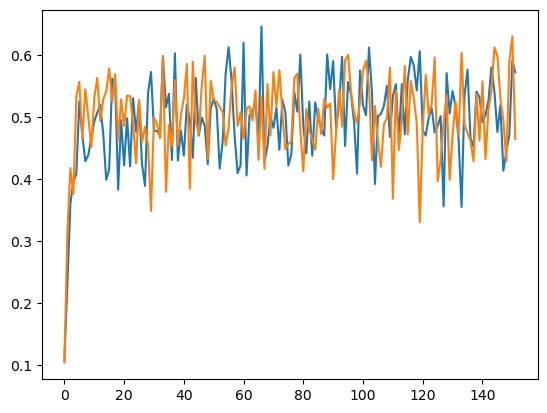

In [15]:
# plot val_losses, train_losses on the same plot
plt.plot(val_losses) # azul
plt.plot(train_losses) # laranja

0.5009236


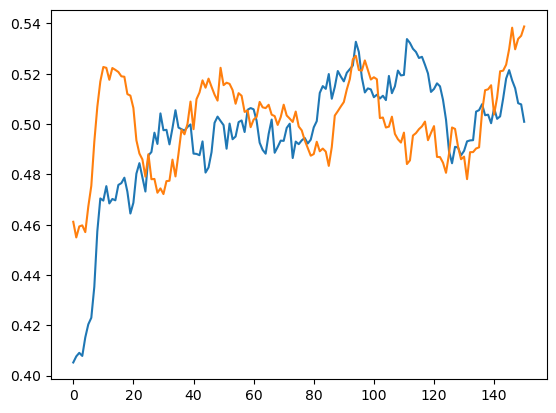

In [16]:
from scipy.ndimage import uniform_filter1d

aa = np.array(val_losses[1:])
aa = uniform_filter1d(aa, size=15)
plt.plot(aa)
print(aa[-1])

aa = np.array(train_losses[1:])
aa = uniform_filter1d(aa, size=15)
plt.plot(aa)

In [13]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network2(nn.Module):
    def __init__(self):
        super().__init__()

        #self.unet = ASPP_Net(7, 16)
        self.unet = ASPP_Unet(7, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x = (x > 0.5).float()

        return x

    
model = Network2().to(device)
model.load_state_dict(torch.load("modelSeg.pth"))

<All keys matched successfully>

In [14]:
def f1_score2(dl):
    model.eval()

    im, lb = next(iter(val_dl))
    pi, ci, ni = im
    pl, cl, nl = lb

    output = ((model(ci) - model(pi)) > 0.5).float()
    dff = ((cl - pl) > 0.5).float()[:, None, ...]

    intersection = torch.sum(output * dff)
    union = torch.sum(output) + torch.sum(dff) - intersection

    tp = torch.sum(output * dff)
    fp = torch.sum(output * (1-dff))
    fn = torch.sum((1-output) * dff)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    iou = intersection / union

    print(f"F1: {f1:.4f} IoU: {iou:.4f}")

    model.train()

    return f1.detach().cpu().numpy() #, iou.detach().cpu().numpy()

In [34]:
S = 0
for i in range(16):
    S += f1_score2(val_dl)
S/16

F1: 0.5522 IoU: 0.3814
F1: 0.5173 IoU: 0.3489
F1: 0.5193 IoU: 0.3507
F1: 0.4166 IoU: 0.2631
F1: 0.4599 IoU: 0.2986
F1: 0.4200 IoU: 0.2659
F1: 0.4632 IoU: 0.3014
F1: 0.4550 IoU: 0.2945
F1: 0.4743 IoU: 0.3109
F1: 0.4900 IoU: 0.3245
F1: 0.5577 IoU: 0.3867
F1: 0.5385 IoU: 0.3685
F1: 0.4690 IoU: 0.3064
F1: 0.3871 IoU: 0.2400
F1: 0.4487 IoU: 0.2892
F1: 0.4441 IoU: 0.2854


0.4758099168539047